# Exercise 5 : Probabilistic Time Series Forecasting with Transformers

<img src=https://huggingface.co/blog/assets/118_time-series-transformers/thumbnail.png width="750">

## Introduction

Time series forecasting is an essential scientific and business problem and as such has also seen a lot of innovation recently with the use of [deep learning based](https://dl.acm.org/doi/abs/10.1145/3533382) models in addition to the [classical methods](https://otexts.com/fpp3/).

In this exercise we will train a single probabilistic Transformer model on the `tourism_monthly` dataset (part of a past [Kaggle competition](https://www.kaggle.com/c/tourism1/overview); [associated paper](https://www.sciencedirect.com/science/article/abs/pii/S016920701000107X?via%3Dihub)), which is available on the [Hugging Face Hub](https://huggingface.co/datasets/monash_tsf). This dataset contains monthly tourism volumes for 366 regions in Australia (so we have 366 time series).

An Encoder-Decoder architecture is helpful at inference time where typically for some logged data we wish to forecast some prediction steps into the future. This can be thought of as analogous to the text generation task where given some context, we sample the next token and pass it back into the decoder (also called "autoregressive generation").

Due to the time and memory constraints of the attention mechanism, we'll consider some appropriate context window and sample this window and the subsequent prediction length sized window from the training data when constructing batches. The context sized window can be passed to the encoder and the prediction window to a causal-masked decoder.

## Set-up
Install the necessary libraries: 🤗 Transformers, 🤗 Datasets, 🤗 Evaluate,  🤗 Accelerate and [GluonTS](https://github.com/awslabs/gluonts).

In [1]:
!pip install -q transformers
!pip install -q datasets
!pip install -q evaluate
!pip install -q accelerate
!pip install -q gluonts ujson

In [2]:
from transformers import set_seed

set_seed(42)

## Data loading

In [3]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "tourism_monthly")
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]
test_dataset = dataset["test"]

freq = "1M"

dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

Each observation in the dataset has different fields:

In [4]:
train_example = dataset["train"][0]
validation_example = dataset["validation"][0]
test_example = dataset["test"][0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

The `start` simply indicates the start of the time series (as a datetime), while the `target` contains the actual values of the time series.
`feat_static_cat` is a field for categorical variables that remain fixed (static) during the time series; in this case there's only the ID of the region it refers to. `feat_dynamic_real` is for real-valued features which are static over time, but in this case the field is empty. `item_id` is once again a simple identifier of the time series.

The `start` will be useful to add time related features to the time series values, as extra input to the model (such as "month of year").

Note that the validation set contains the same data as the training set, just for a `prediction_length` longer amount of time. This allows us to validate the model's predictions against the ground truth. The test set is again one `prediction_length` longer data compared to the validation set, to get results against completely unseen data.

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375]
Length of the training sequence 139
Length of the validation sequence 163
Length of the testing sequence 187 




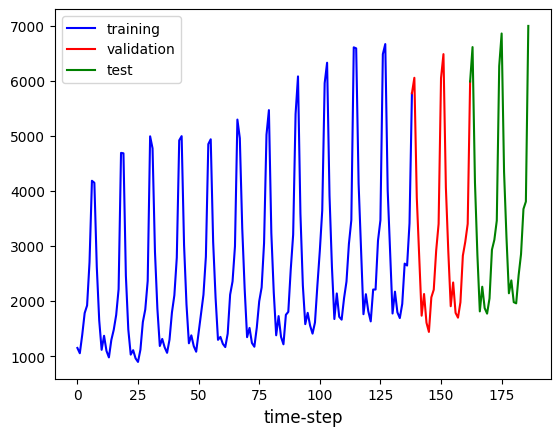

In [5]:
print(train_example["start"])
print(train_example["target"][:5])
print(f"Length of the training sequence {len(train_example['target'])}")
print(f"Length of the validation sequence {len(validation_example['target'])}")
print(f"Length of the testing sequence {len(test_example['target'])} \n\n")

import matplotlib.pyplot as plt

prediction_length = 24

figure, axes = plt.subplots()
axes.plot(range(len(train_example["target"])),train_example["target"], color="blue",label="training")
axes.plot(range(len(train_example["target"])-1,
                len(train_example["target"]) + prediction_length), validation_example["target"][-prediction_length-1:], color="red",label="validation")
axes.plot(range(len(train_example["target"]) + prediction_length -1,
                len(train_example["target"]) + 2*prediction_length), test_example["target"][-prediction_length-1:],color="green",label="test")
plt.legend(loc="best", fontsize=10)
plt.xlabel("time-step", fontsize=12)

plt.show()

We convert `start` of each observation to be a `pd.Period` object, as this will come in handy later to construct additional features.

In [6]:
from functools import lru_cache
from functools import partial
import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))
validation_dataset.set_transform(partial(transform_start_field, freq=freq))

## Model definition

## Define the model

Next, let's instantiate the model. It will be trained from scratch, hence we won't use the `from_pretrained` method here, but rather randomly initialize the model from a [`config`](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerConfig).

We specify a couple of additional parameters to the model:
- `prediction_length` = 24: horizon that the decoder of the Transformer will learn to predict for;
- `context_length` = 48: the length of the window considered;
- `lags` : these specify how much we "look back", in a smart way given the frequency of observations, to be added as additional features.
- the number of time features: in our case, this will be 2 as we'll add `MonthOfYear` and `Age` (how "old" the time series is at each step) features;
- the cardinality: the number of values of each static categorical feature, as a list which for our case will be [366] as we have 366 different time series
- the embedding dimension: the embedding dimension as a list, for example [3] meaning the model will learn an embedding vector of size 3 for each of the 366 time series (regions).


![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*KKfUW5qbn87JeBVbf91x4A.png)

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*YzBUzokB0ShcSG87Yi9CtA.png)

In [7]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq) # simply a float representing the month as a new feature
print(time_features)

from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[<function month_of_year at 0x7a97bd8f8670>]
[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


#### TODO: Intuitively, does the sequence proposed above make sense for monthly data? Why?

In [8]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=prediction_length*2,
    lags_sequence=lags_sequence,
    num_time_features= 2, # month of year + "age"
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    embedding_dimension=[2],

    # transformer params:
    encoder_layers=4, # N_x
    decoder_layers=4, # N_x
    d_model=32,

    # NOTE: Other hyperparams could be tuned here like encoder_attention_heads, decoder_attention_heads, dropout, FF dimension, etc...
)

model = TimeSeriesTransformerForPrediction(config)

Let's take a look at the actual structure of the model (also link to [source](https://github.com/huggingface/transformers/blob/v4.35.2/src/transformers/models/time_series_transformer/modeling_time_series_transformer.py#L1238)). This is essentially a standard transformer model.

<img src=https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png width="500">

In [9]:
model
# (22 = 16 (len(lags) + 2 * 1 (univariate) + embedding size + number of features (month+age) )) TimeSeriesValueEmbedding
# (72 = context_length (48) + prediction_length (24)) TimeSeriesSinusoidalPositionalEmbedding

TimeSeriesTransformerForPrediction(
  (model): TimeSeriesTransformerModel(
    (scaler): TimeSeriesMeanScaler()
    (embedder): TimeSeriesFeatureEmbedder(
      (embedders): ModuleList(
        (0): Embedding(366, 2)
      )
    )
    (encoder): TimeSeriesTransformerEncoder(
      (value_embedding): TimeSeriesValueEmbedding(
        (value_projection): Linear(in_features=22, out_features=32, bias=False)
      )
      (embed_positions): TimeSeriesSinusoidalPositionalEmbedding(72, 32)
      (layers): ModuleList(
        (0-3): 4 x TimeSeriesTransformerEncoderLayer(
          (self_attn): TimeSeriesTransformerAttention(
            (k_proj): Linear(in_features=32, out_features=32, bias=True)
            (v_proj): Linear(in_features=32, out_features=32, bias=True)
            (q_proj): Linear(in_features=32, out_features=32, bias=True)
            (out_proj): Linear(in_features=32, out_features=32, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((32,), eps=1e-05, element

Note that this is a so-called probabilistic forecasting model, not a point forecasting model. This means that the model learns a distribution, from which one can sample. By default, the model uses a Student-t distribution. This is an important difference with Transformers for NLP, where the head typically consists of a fixed categorical distribution implemented as an `nn.Linear` layer.

In [10]:
model.config.distribution_output

'student_t'

#### TODO: Why is it generally sensible to establish a distribution and subsequently sample from it for forecasting purposes? What drawbacks might arise from predicting a fixed point at each time-step?

#### Important Note:

The model is trained using “teacher-forcing”, similar to how a Transformer is trained for machine translation. This means that, during training, one shifts the future_values one position to the right as input to the decoder, prepended by the last value of past_values. At each time step, the model needs to predict the next target. So the set-up of training is similar to a GPT model for language, except that there's no notion of `decoder_start_token_id` (we just use the last value of the context as initial input for the decoder). In practice we say the model is auto-regressive.


At inference time, we give the final value of the past_values as input to the decoder. Next, we can sample from the model to make a prediction at the next time step, which is then fed to the decoder in order to make the next prediction (also called autoregressive generation).

## Transformations

Next, we define the transformations for the data, in particular for the creation of the time features (based on the dataset or universal ones). This is done using the GluonTS library.

At a high level, we will iterate over the individual time series of our dataset and add/remove fields or features:

In [11]:
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    TestSplitSampler,
    ValidationSplitSampler,
    Transformation,
    VstackFeatures,
    RenameFields,
)
from transformers import PretrainedConfig


def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:

    # remove some fields we're not going to use
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

## Define `InstanceSplitter`

For training/validation/testing we next create an `InstanceSplitter` which is used to sample windows from the dataset.

The instance splitter samples random `context_length` sized and subsequent `prediction_length` sized windows from the data.

This makes sure that the `values` will be split into `past_values` and subsequent `future_values` keys, which will serve as the encoder and decoder inputs respectively.

In [12]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

## Create DataLoaders

Dataloaders allow us to have batches of (input, output pairs) - or in other words (`past_values`, `future_values`).

In [13]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [14]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [15]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

#### TODO check the dimensions of each batch of the training dataloader (for all different keys)

In [16]:
# TODO

In [ ]:
#@title Solution

batch = next(iter(train_dataloader))

for k, v in batch.items():
    print(k, v.shape, v.type())

#### TODO: given the dimensions obtained above, give an interpretation on how these tensors might interact within the transformer.

## Training

## Train the Model

It's time to train the model! We'll use a standard PyTorch training loop.

We will use the 🤗 [Accelerate](https://huggingface.co/docs/accelerate/index) library here, which automatically places the model, optimizer and dataloader on the appropriate `device`.

In [18]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

for epoch in range(40):
    train_running_loss = 0

    model.train()
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device),
            static_real_features=None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss
        train_running_loss += loss.item()

        accelerator.backward(loss)
        optimizer.step()

    print(f"Epoch {epoch+1}: Train loss: {train_running_loss}")

Epoch 1: Train loss: 806.6572918891907
Epoch 2: Train loss: 765.7081127166748
Epoch 3: Train loss: 743.639319896698
Epoch 4: Train loss: 733.0729031562805
Epoch 5: Train loss: 728.8970174789429
Epoch 6: Train loss: 726.367612361908
Epoch 7: Train loss: 722.8259530067444
Epoch 8: Train loss: 722.585702419281
Epoch 9: Train loss: 721.3031315803528
Epoch 10: Train loss: 719.614381313324
Epoch 11: Train loss: 719.7479844093323
Epoch 12: Train loss: 715.288031578064
Epoch 13: Train loss: 718.4713220596313
Epoch 14: Train loss: 717.3346347808838
Epoch 15: Train loss: 714.2860207557678
Epoch 16: Train loss: 716.7659697532654
Epoch 17: Train loss: 716.2451324462891
Epoch 18: Train loss: 714.1672387123108
Epoch 19: Train loss: 713.6069893836975
Epoch 20: Train loss: 714.1530723571777
Epoch 21: Train loss: 713.1825094223022
Epoch 22: Train loss: 714.2538495063782
Epoch 23: Train loss: 714.295970916748
Epoch 24: Train loss: 711.2252039909363
Epoch 25: Train loss: 713.163724899292
Epoch 26: Train 

## Prediction

We use the `generate()` method for autoregressive generation.

We will sample the very last `context_length` sized window of values from each time series in the dataset, and pass it to the model.

The model will autoregressively sample a certain number of values from the predicted distribution and pass them back to the decoder to return the prediction outputs:

In [19]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device),
        static_real_features=None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

The model outputs a tensor of shape (`batch_size`, `number of samples`, `prediction length`). We'll stack the forecasts for all batches vertically, to getting all forecasts for the time-series in the test dataset.

In this case, we get `100` possible values for the next `24` months for every time series:

In [20]:
forecasts = np.vstack(forecasts)
print(forecasts[0].shape)

(100, 24)


We can evaluate the resulting forecast with respect to the ground truth out of sample values present in the test set. For that, we'll use the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library, which includes the MASE metric (i.e., the mean absolute error of the forecast values, divided by the mean absolute error of the in-sample one-step naive forecast).

In [21]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")


forecast_median = np.median(forecasts, 1)

mase_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

print(f"MASE: {round(np.mean(mase_metrics), 3)}")

MASE: 1.268


We can also plot the distribution of MASE scores in the dataset and observe that a handful of time series contribute a lot to the final test metric:

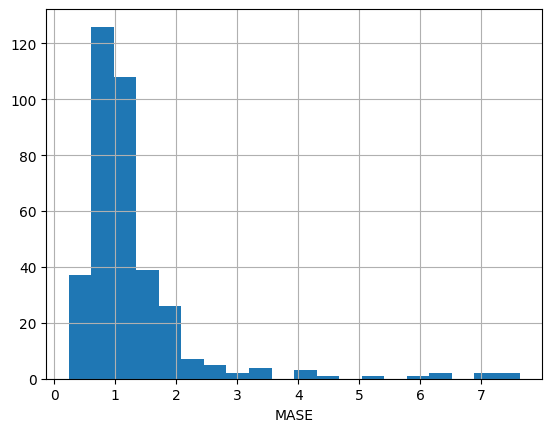

In [22]:
plt.hist(mase_metrics, bins = 20)
plt.xlabel("MASE")
plt.grid("on")
plt.show()

#### TODO: Check how MASE is calculated, give an interpretation about the results obtained for our model.

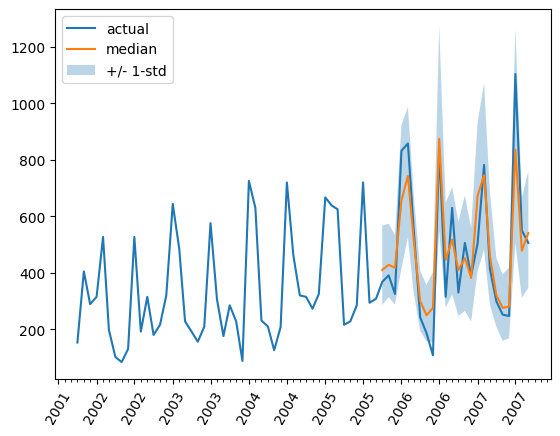

In [23]:
import matplotlib.dates as mdates

# Helper function to plot out forecasts for a time series

def plot_forecast(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-3 * prediction_length :],
        test_dataset[ts_index]["target"][-3 * prediction_length :],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )

    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
        alpha=0.3,
        interpolate=True,
        label="+/- 1-std",
    )
    plt.xticks(rotation=60)
    plt.legend()
    plt.show()

    return

# for example
plot_forecast(300)

#### TODO check the best and worst predictions in terms of MASE by our model and plot them out using the helper functon plot

In [24]:
# TODO

In [ ]:
#@title Solution

worst_index = np.argmax(np.array(mase_metrics))

# want to check more bad predictions? uncomment the next and use these indices in the plot function
# bad_indices = np.argpartition(mase_metrics, -4)[-4:]

best_index = np.argmin(np.array(mase_metrics))

plot_forecast(int(worst_index))
plot_forecast(int(best_index))

## Conclusions

How do we compare against other models? The [Monash Time Series Repository](https://forecastingdata.org/#results) has a comparison table of test set MASE metrics which we can compare to:

|Dataset | 	SES| 	Theta | 	TBATS| 	ETS	| (DHR-)ARIMA| 	PR|	CatBoost |	FFNN	| DeepAR | 	N-BEATS | 	WaveNet| 	**Transformer** (Our) |
|:------------------:|:-----------------:|:--:|:--:|:--:|:--:|:--:|:--:|:---:|:---:|:--:|:--:|:--:|
|Tourism Monthly | 	3.306 |	1.649 |	1.751 |	1.526|	1.589|	1.678	|1.699|	1.582	| 1.409	| 1.574|	1.482	|  **1.268**|

Note that, with our model, we're beating all other models reported, and we didn't do any hyperparameter tuning, nor validation. We just trained the Transformer for 40 epochs. We can certainly improve just considering that.


Of course, we need to be careful with just claiming state-of-the-art results on time series with neural networks, as it seems ["XGBoost is typically all you need"](https://www.sciencedirect.com/science/article/pii/S0169207021001679).  This particular dataset, however, seems to indicate that transformers are definitely worth exploring.